In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import RobustScaler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train = pd.read_csv("/kaggle/input/ventilator-pressure-prediction/train.csv", index_col=[0])
test = pd.read_csv("/kaggle/input/ventilator-pressure-prediction/test.csv", index_col=[0])

In [3]:
train.shape

(6036000, 7)

In [4]:
print(train.columns)

Index(['breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure'], dtype='object')


In [5]:
feature_cols = ["R","C", "u_in", "u_out"]

In [6]:
RS = RobustScaler()
train[feature_cols] = RS.fit_transform(train[feature_cols])
test[feature_cols] = RS.transform(test[feature_cols])

In [7]:
n_steps = 80
n_features = len(feature_cols)

In [8]:
print(train.columns)

Index(['breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure'], dtype='object')


In [9]:
n_steps = 80
n_features = len(feature_cols)
target_column_name = 'pressure'  # Replace with the actual target column name

# Assuming "train" is a DataFrame containing your training data
n_samples_train = len(train) // n_steps  # Calculate the number of breaths
y_train = train[target_column_name].values[:n_samples_train * n_steps].reshape(-1, n_steps)
X_train = train[feature_cols].values[:n_samples_train * n_steps].reshape(-1, n_steps, n_features)

print(X_train.shape, y_train.shape)

(75450, 80, 4) (75450, 80)


In [10]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [11]:
def get_bilstm_tcn_model(n_steps, n_features):
    input_layer = layers.Input(shape=(n_steps, n_features))
    x = input_layer

    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)

    # Temporal Convolutional Network (TCN) layers
    x = layers.Conv1D(256, kernel_size=3, activation='swish', padding='causal', kernel_regularizer=l2(1e-4))(x)
    x = layers.Conv1D(256, kernel_size=3, activation='swish', padding='causal', kernel_regularizer=l2(1e-4))(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    # Flatten the output
    x = layers.Flatten()(x)

    # Dense layers
    x = layers.Dense(512, activation='swish', kernel_regularizer=l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='swish', kernel_regularizer=l2(1e-4))(x)
    output_layer = layers.Dense(80)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

n_steps = 80
n_features = len(feature_cols)  # You should define feature_cols somewhere

model = get_bilstm_tcn_model(n_steps, n_features)

# Compile the model
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss="mae")

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 4)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 80, 512)          534528    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 80, 512)          1574912   
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 80, 256)           393472    
                                                                 
 conv1d_1 (Conv1D)           (None, 80, 256)           196864    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 40, 256)          0     

In [12]:
# Learning rate scheduler and early stopping
scheduler = ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=1e4, decay_rate=1e-5
)
cb_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
cb_es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=512,
    callbacks=[cb_es, cb_lr]
)

Epoch 1/200
118/118 [==============================] - 51s 274ms/step - loss: 2.7787 - val_loss: 1.4326 - lr: 0.0010
Epoch 2/200
118/118 [==============================] - 31s 265ms/step - loss: 1.4697 - val_loss: 1.2030 - lr: 9.9885e-04
Epoch 3/200
118/118 [==============================] - 35s 301ms/step - loss: 1.2941 - val_loss: 1.0638 - lr: 9.9770e-04
Epoch 4/200
118/118 [==============================] - 33s 283ms/step - loss: 1.1751 - val_loss: 0.9585 - lr: 9.9655e-04
Epoch 5/200
118/118 [==============================] - 33s 278ms/step - loss: 1.0860 - val_loss: 0.9104 - lr: 9.9541e-04
Epoch 6/200
118/118 [==============================] - 33s 280ms/step - loss: 1.0362 - val_loss: 0.8973 - lr: 9.9426e-04
Epoch 7/200
118/118 [==============================] - 33s 282ms/step - loss: 0.9842 - val_loss: 0.8242 - lr: 9.9312e-04
Epoch 8/200
118/118 [==============================] - 33s 281ms/step - loss: 0.9518 - val_loss: 0.8304 - lr: 9.9197e-04
Epoch 9/200
118/118 [===============

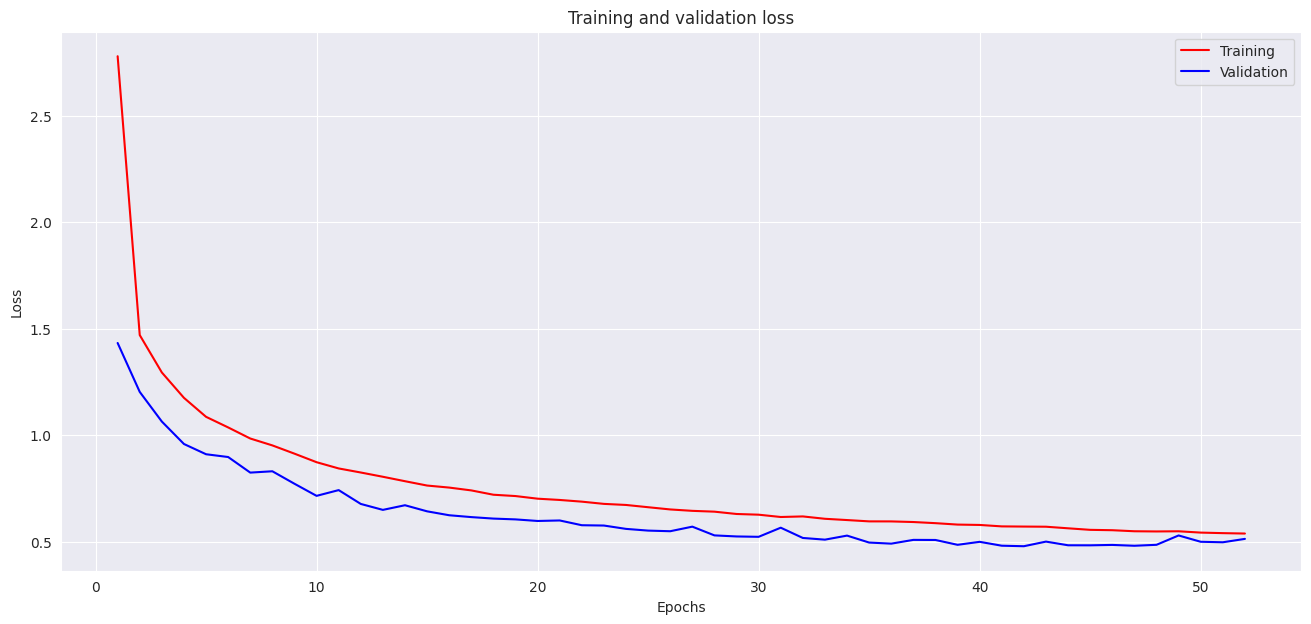

In [13]:
plt.figure(figsize=(16,7))
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(loss)+1)

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.legend(["Training", "Validation" ])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss')

plt.show()

1/1 [==============================] - 1s 1s/step


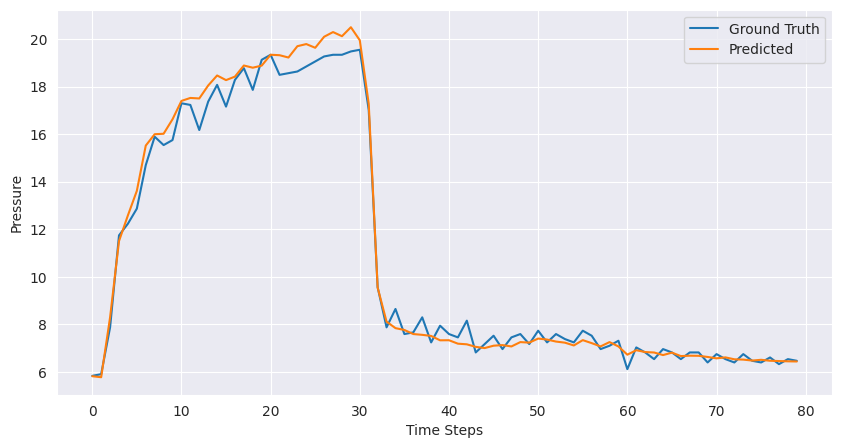

In [14]:
idx = 1
df_plot = train[train['breath_id'] == idx]
p = model.predict(df_plot[feature_cols].values.reshape(-1, n_steps, n_features))
x = range(len(df_plot))  # Use the length of df_plot for x values
y = df_plot['pressure']
plt.figure(figsize=(10, 5))
sns.lineplot(x=x, y=y, label="Ground Truth")
sns.lineplot(x=x, y=p.reshape(-1), label="Predicted")
plt.legend()
plt.ylabel("Pressure")
plt.xlabel("Time Steps")
plt.show()